In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

#my libraries
import sys
sys.path.append("../code")

import myUtilities

import importlib
importlib.reload(myUtilities)


<module 'myUtilities' from 'd:\\education\\sem 9 SIGMA\\convex optimization\\lab 3\\notebooks\\../code\\myUtilities.py'>

In [2]:
#parameters
image_name = "babun"
image_path = f"../resources/{image_name}.png"
seed = 42
noise_ratio = 0.7
dimension = 256
kernel_size = 3

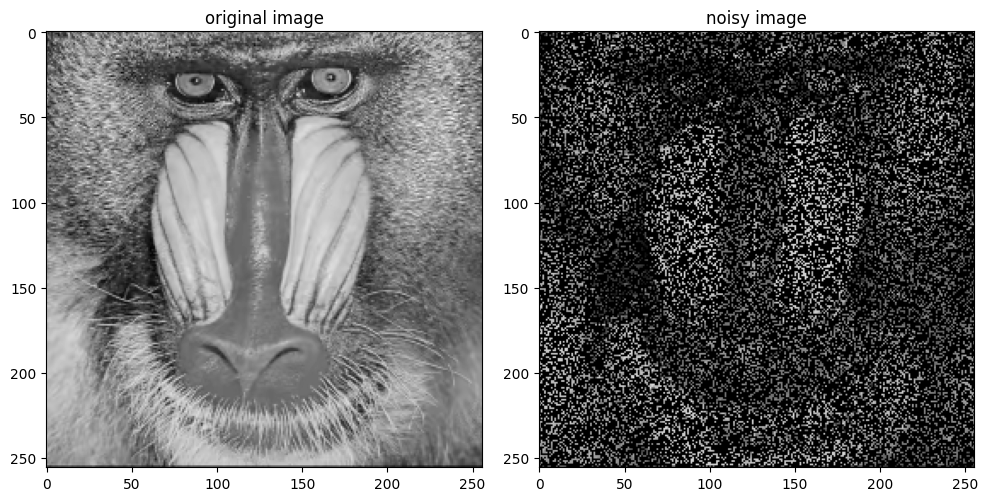

In [3]:
#import the original 
img_OG = cv.resize(cv.imread(image_path,0) , (dimension,dimension))

#add noise
dim = img_OG.shape[0] #image dimension for one axis
noise_indeces = myUtilities.define_noise_mask(dim,noise_ratio,seed = seed)
img_noisy = myUtilities.mask_Image(img_OG,noise_indeces)

#plot original and noisy image

fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # figsize adjusts the overall figure size

ax[0].imshow(img_OG,'gray')
ax[0].set_title('original image')

ax[1].imshow(img_noisy,'gray')
ax[1].set_title('noisy image')

plt.tight_layout()
plt.show()

using a median filter to initialise the DR method

In [4]:
def apply_kernel(image,kernel_size):
    # Get image dimensions
    rows, cols = image.shape
    
    # Create an output image of the same size
    output_image = np.zeros_like(image)
    
    # Define kernel size
    pad = kernel_size // 2
    
    # Iterate over each pixel in the image
    for i in range(pad, rows - pad):
        for j in range(pad, cols - pad):
            # Extract the 5x5 neighborhood (kernel) around the current pixel
            neighborhood = image[i - pad:i + pad + 1, j - pad:j + pad + 1]
            
            # Flatten the neighborhood into a 1D array and remove zeros
            non_zero_values = neighborhood[neighborhood != 0]
            
            # If no non-zero values, retain the original pixel (or handle as needed)
            if non_zero_values.size == 0:
                median_value = 0
            else:
                # Calculate the median of the non-zero values
                median_value = np.median(non_zero_values)
            
            # Set the output pixel to the computed median
            output_image[i, j] = median_value
    
    return output_image


In [5]:
#testing the method
temp = apply_kernel(img_noisy,kernel_size)
img_med_init = myUtilities.fill_zero(np.abs(temp / np.max(temp)))

Rachford method

In [6]:
#inner parameters and variables to use in the implementaion
def fft2d(input_array):
    """Perform 2D FFT (Fast Fourier Transform)"""
    return np.fft.fft2(input_array)

def ifft2d(input_array):
    """Perform 2D IFFT (Inverse Fast Fourier Transform)"""
    return np.fft.ifft2(input_array)


img_given = img_noisy

mask_indx = noise_indeces
mask_indx_inv = myUtilities.invert_mask(dimension, noise_indeces)

init_fft = fft2d(img_med_init/10)

x0 = np.abs(init_fft)
phase = np.angle(init_fft)

ro = 0.5
gamma = 2
gamma2 = 0.01
gamma3 = 1

In [7]:
import numpy as np


def prox_f(x, gamma):
    """
    Proximity operator for the function f.
    """
    # Proximal operator of l1-norm (for sparsity problems)
    return np.sign(x) * np.maximum(0, np.abs(x) - gamma)


def prox_g(x,y,inv_mask_indeces):
    """
    Proximity operator for the function g.
    """
    # Proximal operator of the indicator function for Ax = y

    #comput x_sp the ifft of x    
    x_sp = np.abs(ifft2d(x * np.exp(1j * phase)))
    #x_sp /= np.max(x_sp)
    print(np.max(x_sp))

    y = y.astype(float)
    y /= np.max(y)
    
    #set the values of x_sp to the given image
    x_sp = myUtilities.reset_pixels(y,x_sp,inv_mask_indeces)
    #comput and return x the ifft of x_sp
    x = np.abs(fft2d(x_sp))
    return x

from skimage.restoration import denoise_tv_chambolle

def prox_tv(x, weight):
    x_sp = np.abs(ifft2d(x * np.exp(1j * phase)))
    x_sp /= np.max(x_sp)
    temps = denoise_tv_chambolle(x_sp, weight=weight)
    tempf = np.abs(fft2d(temps))
    return tempf


from scipy.ndimage import laplace
from skimage import img_as_float

def prox_sharp(x, weight):
    """
    Proximal operator to enforce image sharpness.
    
    Parameters:
    - x: Current image estimate.
    - weight: Strength of the sharpening constraint.
    
    Returns:
    - x_sharp: Sharpened image.
    """
    # Convert image to float (if not already)
    x_sp = np.abs(ifft2d(x * np.exp(1j * phase)))
    x_sp /= np.max(x_sp)

    temp = img_as_float(x_sp)
    
    # Apply Laplacian filter to detect edges
    edges = laplace(temp)
    
    # Enhance edges by adding the weighted edge map to the original image
    x_sharp = temp + weight * edges
    
    # Clip values to ensure they remain valid image intensities
    temp2 = np.clip(x_sharp, 0, 1)
    return np.abs(fft2d(temp2))

NMSE_values = []
def douglas_rachford(f, g, tv, x0, ro, gamma, x_OG, max_iter=1000, tol=1e-6):
    """
    Extended Douglas-Rachford algorithm for minimizing f(x) + g(x) + tv(x).
    
    Parameters:
    - f, g, tv: Proximity operators for the functions f, g, and the total variation (TV).
    - x0: Initial guess.
    - ro: Step size (proximity parameter).
    - gamma: Regularization parameter for the TV denoising.
    - x_OG: Original image for NMSE calculation.
    - max_iter: Maximum number of iterations.
    - tol: Convergence tolerance.
    
    Returns:
    - x: Solution to the problem.
    - NMSE_values: List of NMSE values across iterations.
    """
    xk = x0  # Initialize x
    xk_wave = xk  # Initialize intermediate variable
    
    for i in range(max_iter):
        xk_wave = f(xk, gamma)
        if(i % 2 == 0):
            # Apply proximity operator for f                    
            xk = xk + 2 * ro * (tv(2*xk_wave - xk,gamma2)-xk_wave)
        if(i % 2 == 1):        
            xk = xk + 2 * ro * (g(2*xk_wave - xk, img_given, mask_indx_inv)-xk_wave)
        # Apply sharpness operator
        #xk_wave  = prox_sharp(xk_wave, gamma3)
        # Update xk with reflection step


        # Compute NMSE for monitoring convergence
        denoised_img = np.abs(ifft2d(xk * np.exp(1j * phase)))
        NMSE_values.append(myUtilities.NMSE(x_OG / np.max(x_OG), denoised_img / np.max(denoised_img)))
        
        # Check for convergence
        if len(NMSE_values) > 1 and np.abs(NMSE_values[-1] - NMSE_values[-2]) < tol:
            print(f"Convergence achieved at iteration {i}.")
            return xk, NMSE_values
    
    print("Maximum iterations reached.")
    return xk, NMSE_values


0.936962521617242
0.9812686841801462
0.9671889520417979
0.9654978321137252
0.95999175045109
0.9591499709201579
0.9588664163705412
0.9586126205247321
0.9584110005837592
0.9582021043704474
0.9580477821451092
0.9578907969987834
0.9577492536976266
0.9576178442789574
0.9575008352200852
0.9573899060003108
0.9572982113500287
0.957213794865973
0.957140708622474
0.9570754426817324
0.9570186143753118
0.9569685800961945
0.9569250165559223
0.9568869822903169
0.9568538538856055
0.9568250232046897
0.9567999465267832
0.9567781841289356
0.956759292156779
0.9567429301472233
0.9567287526314644
0.9567164929606448
0.9567058877266755
0.9566967289376396
0.9566888175904421
0.9566819927912342
0.9566761048557452
0.9566710304010653
0.9566666571376817
0.9566628911754115
0.9566596484556643
0.9566568579924443
0.9566544569864492
0.9566523920537507
0.956650616370532
0.9566490899648745
0.9566477779919123
0.9566466506285263
0.9566456819908008
0.9566448498956397
Maximum iterations reached.


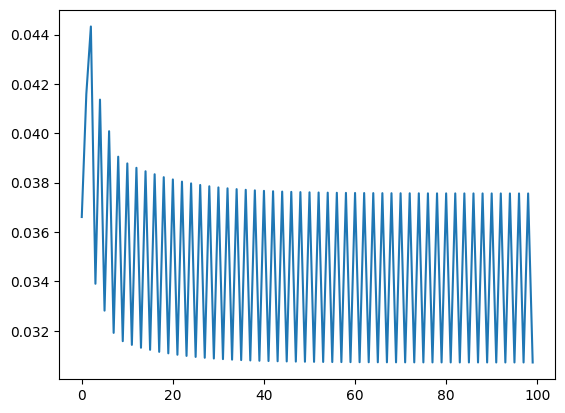

In [8]:
#algorithm testing
x_star,NMSE_values = douglas_rachford(prox_f, prox_g,prox_tv, x0, ro, gamma,img_OG, max_iter=100, tol=1e-6)
fft_result = x_star * np.exp(1j * phase)
ifft_result = ifft2d(fft_result)

img_filtered = np.abs(ifft_result)
plt.plot(NMSE_values)
#np.save(f'../arrays/NMSE_{image_name}_{dimension}_{noise_ratio}_UDR',NMSE_values)

showing the result

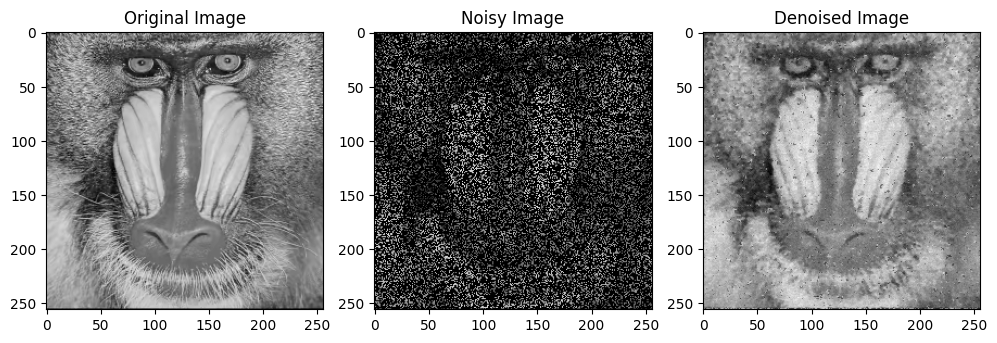

In [9]:
# Create the figure and subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 5))  # figsize adjusts the overall figure size

# Plot original, noisy, and reconstructed (filtered) images
im1 = ax[0].imshow(img_OG, cmap='gray')
ax[0].set_title('Original Image')
#plt.colorbar(im1, ax=ax[0])  # Add color bar for the first subplot

im2 = ax[1].imshow(img_noisy, cmap='gray')
ax[1].set_title('Noisy Image')
#plt.colorbar(im2, ax=ax[1])  # Add color bar for the second subplot

im3 = ax[2].imshow(img_filtered, cmap='gray')
ax[2].set_title('Denoised Image')
#plt.colorbar(im3, ax=ax[2])  # Add color bar for the third subplot

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
regulized_image = (img_filtered * 255).astype(np.uint8)
#cv.imwrite(f'../tests/{image_name}_{dimension}_{noise_ratio}_UDR.jpeg',regulized_image)